In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Problem 1

In [2]:
df=pd.read_excel(r'HW1 P1.xlsx').set_index('Date')
df.index = pd.to_datetime(df.index)t
df

,TMax,TMin
Date,,
1980-01-01,32,23
1980-01-02,33,28
1980-01-03,31,28
1980-01-04,30,26
1980-01-05,32,22
...,...,...
2015-11-26,60,48
2015-11-27,56,34
2015-11-28,38,30


## train:test

In [108]:
print(len(df)*0.8,len(df)*0.2)
train=df.iloc[:-2000]
test=df.iloc[-2000:]

10494.400000000001 2623.6000000000004


In [109]:
train,test

(            TMax  TMin    z_data   zp_data
 Date                                      
 1980-01-01    32    23       NaN       NaN
 1980-01-02    33    28       NaN       NaN
 1980-01-03    31    28       NaN       NaN
 1980-01-04    30    26       NaN       NaN
 1980-01-05    32    22       NaN       NaN
 ...          ...   ...       ...       ...
 2010-06-05    79    60  1.015996  0.817952
 2010-06-06    76    55  0.728990  0.181997
 2010-06-07    70    54  0.671350  0.071318
 2010-06-08    67    58  0.898538  0.295999
 2010-06-09    83    65  1.294945  0.541458
 
 [11118 rows x 4 columns],
             TMax  TMin    z_data   zp_data
 Date                                      
 2010-06-10    77    58  0.894487  0.189512
 2010-06-11    89    64  1.232981  0.575924
 2010-06-12    77    62  1.115382  0.652109
 2010-06-13    71    62  1.112903  0.397882
 2010-06-14    70    60  0.996885  0.430027
 ...          ...   ...       ...       ...
 2015-11-26    60    48  0.357223  1.291245
 20

(-8.432442241326243, 1.8544988019721652e-13, 41, 13076, {'1%': -3.430850197628516, '5%': -2.8617610633246793, '10%': -2.5668876670863447}, 86544.41285813232)


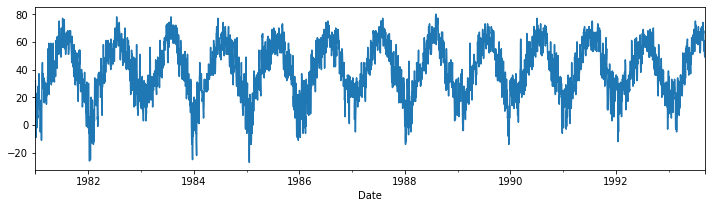

In [110]:
print(adfuller(df['TMin'],autolag='AIC'))
df['TMin'][365:5000].plot(figsize=(12,3))

(-8.28063568678102, 4.5297718437230994e-13, 41, 12712, {'1%': -3.4308645233618735, '5%': -2.8617673940622166, '10%': -2.5668910368920947}, 9488.15503007331)


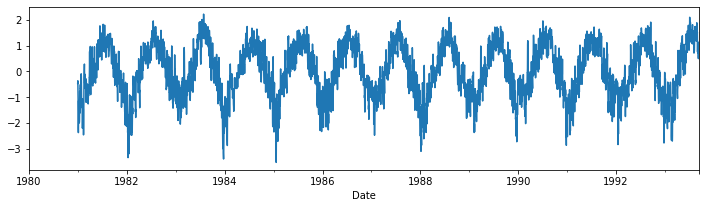

In [111]:
df['z_data'] = (df['TMin'] - df['TMin'].rolling(window=365).mean()) / df['TMin'].rolling(window=365).std()
print(adfuller(df.z_data.dropna(), autolag='AIC'))
df['z_data'][:5000].plot(figsize=(12,3))

(-19.972446830304815, 0.0, 17, 12371, {'1%': -3.430878708867679, '5%': -2.8617736628012023, '10%': -2.5668943737016647}, 17129.70264119736)


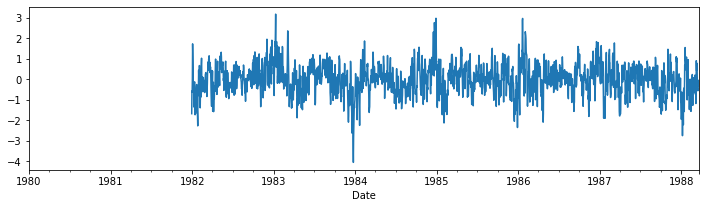

In [112]:
df['zp_data'] = df['z_data'] - df['z_data'].shift(365)
print(adfuller(df.zp_data.dropna(), autolag='AIC'))
df['zp_data'][:3000].plot(figsize=(12,3))

In [117]:
model1 = ExponentialSmoothing(train['TMin'], trend="add", seasonal="add", damped=True,seasonal_periods=365)
model2= ExponentialSmoothing(train['TMin'], trend="add", seasonal="add", damped=False,seasonal_periods=365)
fit1 = model1.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(2500)
pred2 = fit2.forecast(2500)

In [118]:
pred1=pd.DataFrame(pred1, columns=['TMin'])
pred2=pd.DataFrame(pred2, columns=['TMin'])
pred1

,TMin
2010-06-10,61.531671
2010-06-11,61.925692
2010-06-12,63.210137
2010-06-13,64.481778
2010-06-14,63.966575
...,...
2017-04-09,47.086912
2017-04-10,47.581297
2017-04-11,49.619299
2017-04-12,47.663359


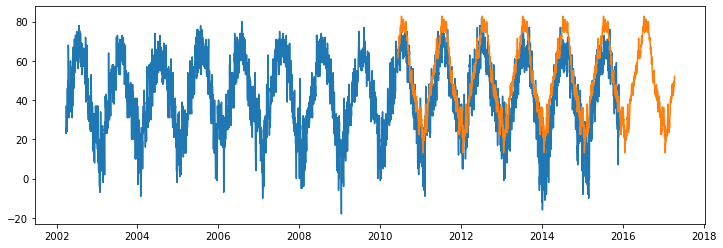

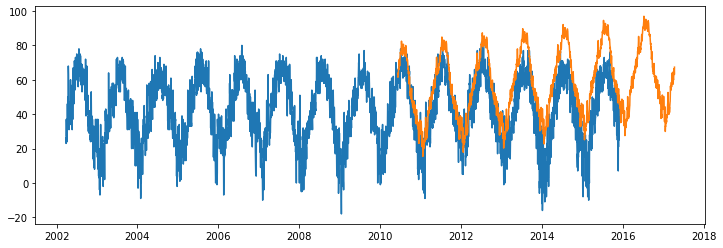

In [119]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['TMin'][-5000:])
ax.plot(pred1)
fig2, bx = plt.subplots(figsize=(12,4))
bx.plot(df['TMin'][-5000:])
bx.plot(pred2)

In [120]:
predhw1=pred1['2015-12':'2016-02']
predhw1["payout"] = np.nan
predhw1

,TMin,payout
2015-12-01,38.775650,NaN
2015-12-02,35.926563,NaN
2015-12-03,34.257054,NaN
2015-12-04,35.151517,NaN
2015-12-05,34.175969,NaN
...,...,...
2016-02-25,27.182206,NaN
2016-02-26,27.560962,NaN
2016-02-27,28.267086,NaN
2016-02-28,25.680232,NaN


In [121]:
predhw1['payout'][0]=0
for i in range(1,len(predhw1)):
    if predhw1['TMin'][i]>=32:
        if predhw1['TMin'][i-1]>=32:
            predhw1['payout'][i]=100000
        else:
            predhw1['payout'][i]=0
    else:
        predhw1['payout'][i]=0
predhw1

,TMin,payout
2015-12-01,38.775650,0.0
2015-12-02,35.926563,100000.0
2015-12-03,34.257054,100000.0
2015-12-04,35.151517,100000.0
2015-12-05,34.175969,100000.0
...,...,...
2016-02-25,27.182206,0.0
2016-02-26,27.560962,0.0
2016-02-27,28.267086,0.0
2016-02-28,25.680232,0.0


### Expected Payout

In [122]:
np.mean(predhw1['payout'])

13186.813186813188

### Shortfall

In [123]:
print(np.percentile(predhw1['payout'],99))
print(np.percentile(predhw1['payout'],1))


100000.0
0.0


# Problem 2

In [15]:
df2=pd.read_excel(r'HW1 P2.xlsx')
df2

,Date,Tetco M3,Unnamed: 2,Dates,TMax,TMin
0,2003-12-01,5.52,NaN,1952-12-01,35,19
1,2003-12-02,6.41,NaN,1952-12-02,35,28
2,2003-12-03,6.86,NaN,1952-12-03,39,35
3,2003-12-04,6.20,NaN,1952-12-04,45,37
4,2003-12-05,6.48,NaN,1952-12-05,50,41
...,...,...,...,...,...,...
23036,NaT,NaN,NaN,2015-12-27,69,49
23037,NaT,NaN,NaN,2015-12-28,53,40
23038,NaT,NaN,NaN,2015-12-29,55,43
23039,NaT,NaN,NaN,2015-12-30,52,47


In [16]:
df2_spot=pd.DataFrame(columns=['Date','Tetco M3'])
df2_spot['Date']=df2['Date']
df2_spot['Tetco M3']=df2['Tetco M3']
df2_spot=df2_spot.dropna()
df2_spot=df2_spot.set_index('Date')
df2_spot

,Tetco M3
Date,
2003-12-01,5.52
2003-12-02,6.41
2003-12-03,6.86
2003-12-04,6.20
2003-12-05,6.48
...,...
2015-09-03,1.46
2015-09-04,1.36
2015-09-05,1.24


In [17]:
df2_tem=pd.DataFrame(columns=['Dates','TMax','TMin'])
df2_tem['Dates']=df2['Dates']
df2_tem['TMax']=df2['TMax']
df2_tem['TMin']=df2['TMin']
df2_tem=df2_tem.set_index('Dates')
df2_tem.index.names = ['Date']
df2_tem

,TMax,TMin
Date,,
1952-12-01,35,19
1952-12-02,35,28
1952-12-03,39,35
1952-12-04,45,37
1952-12-05,50,41
...,...,...
2015-12-27,69,49
2015-12-28,53,40
2015-12-29,55,43


Predict Temperature

In [59]:
print(len(df2_tem)*0.8,len(df2_tem)*0.2)
train=df2_tem.iloc[:-1000]
test=df2_tem.iloc[-1000:]

18432.8 4608.2


In [60]:
print(adfuller(df2_tem['TMin'],autolag='AIC'))
df2_tem['z_min'] = (df2_tem['TMin'] - df2_tem['TMin'].rolling(window=365).mean()) / df2_tem['TMin'].rolling(window=365).std()
print(adfuller(df2_tem.z_min.dropna(), autolag='AIC'))
df2_tem['zp_min'] = df2_tem['z_min'] - df2_tem['z_min'].shift(365)
print(adfuller(df2_tem.zp_min.dropna(), autolag='AIC'))

(-12.203486475843288, 1.2082540415447693e-22, 47, 22993, {'1%': -3.430634435706455, '5%': -2.8616657114869195, '10%': -2.5668369126328714}, 147238.60214138325)
(-12.161628365027937, 1.48906988613193e-22, 47, 22629, {'1%': -3.4306390115315137, '5%': -2.861667733756827, '10%': -2.566837989046478}, 16940.601360116983)
(-25.65797458413185, 0.0, 30, 22281, {'1%': -3.4306435260328225, '5%': -2.8616697289218633, '10%': -2.5668390510332366}, 30622.59107268356)


In [61]:
print(adfuller(df2_tem['TMax'],autolag='AIC'))
df2_tem['z_max'] = (df2_tem['TMax'] - df2_tem['TMax'].rolling(window=365).mean()) / df2_tem['TMax'].rolling(window=365).std()
print(adfuller(df2_tem.z_max.dropna(), autolag='AIC'))
df2_tem['zp_max'] = df2_tem['z_max'] - df2_tem['z_max'].shift(365)
print(adfuller(df2_tem.zp_max.dropna(), autolag='AIC'))

(-11.892742668438087, 5.816828952846519e-22, 47, 22993, {'1%': -3.430634435706455, '5%': -2.8616657114869195, '10%': -2.5668369126328714}, 157055.23785573247)
(-11.904973473537513, 5.463196176950399e-22, 47, 22629, {'1%': -3.4306390115315137, '5%': -2.861667733756827, '10%': -2.566837989046478}, 22539.970850906073)
(-23.285362062551464, 0.0, 33, 22278, {'1%': -3.4306435655641803, '5%': -2.8616697463925687, '10%': -2.5668390603325486}, 36221.57825822459)


In [67]:
modelmin = ExponentialSmoothing(train['TMin'], trend="add", seasonal="add", damped=True,seasonal_periods=365)
modelmax= ExponentialSmoothing(train['TMax'], trend="add", seasonal="add", damped=True,seasonal_periods=365)
fitmin = modelmin.fit()
fitmax = modelmax.fit()
predmin = fitmin.forecast(1200)
predmax = fitmax.forecast(1200)

In [68]:
print(predmin,predmax)

2013-04-06    36.449593
2013-04-07    37.322458
2013-04-08    39.502032
2013-04-09    42.121330
2013-04-10    43.325411
                ...    
2016-07-14    61.004969
2016-07-15    60.681487
2016-07-16    60.017429
2016-07-17    60.963205
2016-07-18    59.836917
Freq: D, Length: 1200, dtype: float64 2013-04-06    60.739600
2013-04-07    62.449057
2013-04-08    64.829278
2013-04-09    67.572169
2013-04-10    69.411127
                ...    
2016-07-14    86.023879
2016-07-15    83.676660
2016-07-16    84.251467
2016-07-17    84.545660
2016-07-18    83.333384
Freq: D, Length: 1200, dtype: float64


In [69]:
pred=pd.DataFrame(predmin, columns=['TMin'])
pred['TMax']=predmax
pred

,TMin,TMax
2013-04-06,36.449593,60.739600
2013-04-07,37.322458,62.449057
2013-04-08,39.502032,64.829278
2013-04-09,42.121330,67.572169
2013-04-10,43.325411,69.411127
...,...,...
2016-07-14,61.004969,86.023879
2016-07-15,60.681487,83.676660
2016-07-16,60.017429,84.251467
2016-07-17,60.963205,84.545660


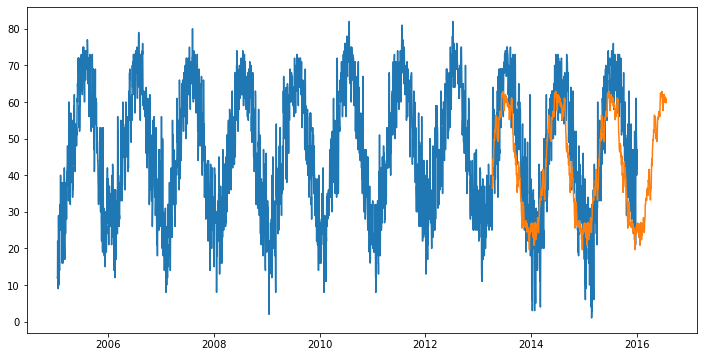

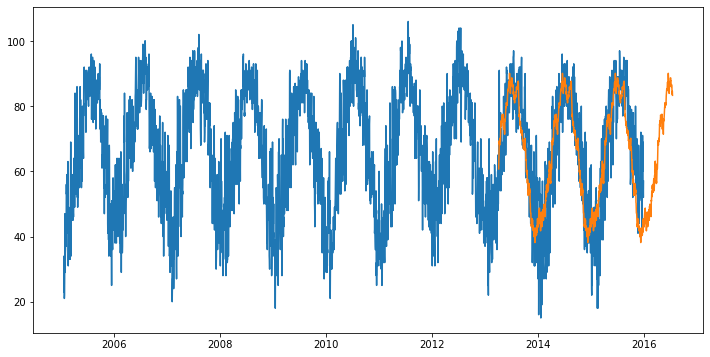

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df2_tem['TMin'][-4000:])
ax.plot(predmin)
fig2, bx = plt.subplots(figsize=(12,6))
bx.plot(df2_tem['TMax'][-4000:])
bx.plot(predmax)

In [124]:
predtem=pd.concat([df2_tem['2003-12-01':'2015-12-31'],pred['2015-12-31':]])
predtem=predtem.drop(columns=['z_min','zp_min','z_max','zp_max'])
predtem

,TMax,TMin
2003-12-01,55.000000,33.000000
2003-12-02,42.000000,28.000000
2003-12-03,37.000000,20.000000
2003-12-04,40.000000,22.000000
2003-12-05,36.000000,30.000000
...,...,...
2016-07-14,86.023879,61.004969
2016-07-15,83.676660,60.681487
2016-07-16,84.251467,60.017429
2016-07-17,84.545660,60.963205


Prediction of stock price, using regression model

In [125]:
predtem['Spot Price']=df2_spot['Tetco M3']
print(predtem)
print(len(df2_spot))

                 TMax       TMin  Spot Price
2003-12-01  55.000000  33.000000        5.52
2003-12-02  42.000000  28.000000        6.41
2003-12-03  37.000000  20.000000        6.86
2003-12-04  40.000000  22.000000        6.20
2003-12-05  36.000000  30.000000        6.48
...               ...        ...         ...
2016-07-14  86.023879  61.004969         NaN
2016-07-15  83.676660  60.681487         NaN
2016-07-16  84.251467  60.017429         NaN
2016-07-17  84.545660  60.963205         NaN
2016-07-18  83.333384  59.836917         NaN

[4615 rows x 3 columns]
4298


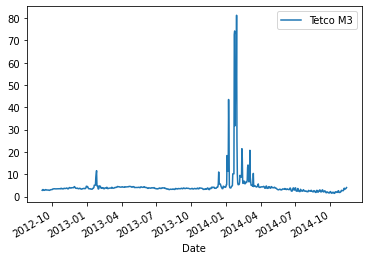

In [126]:
df2_spot[3200:4000].plot()

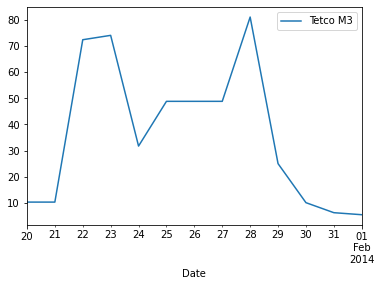

In [127]:
df2_spot['2014-01-20':'2014-02-01'].plot()

In [128]:
traindf=predtem[:-1000].dropna()
#from_ts = '2014-01-20'
#to_ts = '2014-02-01'
#traindf = traindf[(traindf.index < from_ts) | (traindf.index > to_ts)]
#from_ts = '2015-02-01'
#to_ts = '2015-03-01'
#traindf = traindf[(traindf.index < from_ts) | (traindf.index > to_ts)]
y=traindf['Spot Price']
x=traindf.drop(columns='Spot Price')
testdf=predtem[-1000:]
z=testdf.drop(columns='Spot Price')

In [129]:
traindf,len(testdf)

(            TMax  TMin  Spot Price
 2003-12-01  55.0  33.0        5.52
 2003-12-02  42.0  28.0        6.41
 2003-12-03  37.0  20.0        6.86
 2003-12-04  40.0  22.0        6.20
 2003-12-05  36.0  30.0        6.48
 ...          ...   ...         ...
 2013-10-19  65.0  44.0        3.46
 2013-10-20  63.0  42.0        3.46
 2013-10-21  67.0  38.0        3.46
 2013-10-22  64.0  42.0        3.84
 2013-10-23  58.0  42.0        3.86
 
 [3614 rows x 3 columns],
 1000)

In [130]:
y.shape,x.shape

((3614,), (3614, 2))

In [131]:
z

,TMax,TMin
2013-10-24,53.000000,37.000000
2013-10-25,56.000000,36.000000
2013-10-26,56.000000,30.000000
2013-10-27,60.000000,35.000000
2013-10-28,65.000000,33.000000
...,...,...
2016-07-14,86.023879,61.004969
2016-07-15,83.676660,60.681487
2016-07-16,84.251467,60.017429
2016-07-17,84.545660,60.963205


In [132]:
reg1=LinearRegression().fit(x,y)

In [133]:
regspot=reg1.predict(z).tolist()
regspot,len(regspot)

([6.670779413581848,
  6.641297673147612,
  6.745223601827974,
  6.5962150231975,
  6.552852451844905,
  6.513050239825566,
  6.362321582597575,
  6.144029051513526,
  6.064304425336626,
  6.298197865936552,
  6.589334708807431,
  6.866590720759952,
  6.64301775174513,
  6.298197865936552,
  6.4420462087744745,
  6.757384354148817,
  6.809347318488998,
  6.511330161228049,
  6.639577594550095,
  6.842269216118268,
  7.001718468472067,
  6.80062672336319,
  6.73478292810465,
  6.5651334063039695,
  6.273996563433089,
  6.211592925369583,
  6.717582142129478,
  6.949755504131886,
  6.906392932779291,
  6.423005142063563,
  6.712301704198705,
  7.258213335116159,
  7.247772661392834,
  6.819787992212323,
  6.85442996843911,
  7.1299659017941135,
  7.102204239957395,
  7.128245823196596,
  6.958355897119472,
  6.698541075418567,
  6.641297673147612,
  6.736623208840388,
  6.2601157325147305,
  6.466247511277937,
  6.930714437420975,
  7.1872093040650675,
  7.024319894516234,
  7.0399208040

In [134]:
testdf['PredSpot']=regspot
testdf

,TMax,TMin,Spot Price,PredSpot
2013-10-24,53.000000,37.000000,3.82,6.670779
2013-10-25,56.000000,36.000000,3.78,6.641298
2013-10-26,56.000000,30.000000,3.72,6.745224
2013-10-27,60.000000,35.000000,3.72,6.596215
2013-10-28,65.000000,33.000000,3.72,6.552852
...,...,...,...,...
2016-07-14,86.023879,61.004969,NaN,5.739787
2016-07-15,83.676660,60.681487,NaN,5.782009
2016-07-16,84.251467,60.017429,NaN,5.784543
2016-07-17,84.545660,60.963205,NaN,5.763572


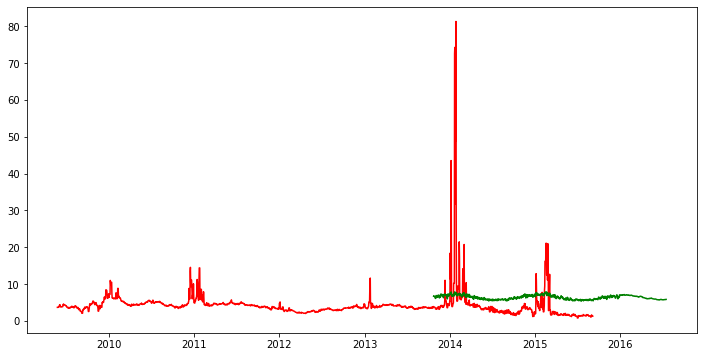

In [135]:
fig3, cx = plt.subplots(figsize=(12,6))
cx.plot(df2_spot[2000:],color='r')
cx.plot(testdf['PredSpot'],color='g')

Calculate Payout

In [150]:
#month	month	T strike	P strike
#1	2015/11/1	50	1.802
#2	2015/12/1	41	2.999
#3	2016/1/1	37	5.295
#4	2016/2/1	38	5.134
#5	2016/3/1	48	2.525

In [154]:
result2=pd.DataFrame()
result2['Month']=['2015-11','2015-12','2016-01','2016-02','2016-03']
result2['TStrike']=[50,41,37,38,48]
result2['PStrike']=[1.802,2.999,5.295,5.134,2.525]

In [155]:
result2

,Month,TStrike,PStrike
0,2015-11,50,1.802
1,2015-12,41,2.999
2,2016-01,37,5.295
3,2016-02,38,5.134
4,2016-03,48,2.525


In [161]:
Pavg=[]
Tavg=[]
for i in range(5):
    avgprice_monthi=np.average(testdf['PredSpot'][result2['Month'][i]])
    avgtemp_monthi=np.average((testdf['TMin'][result2['Month'][i]]+testdf['TMax'][result2['Month'][i]])/2)
    
    Tavg.append(avgtemp_monthi)
    Pavg.append(avgprice_monthi)
result2['Tavg']=Tavg
result2['Pavg']=Pavg

In [165]:
result2

,Month,TStrike,PStrike,Tavg,Pavg,Monthly Payout
0,2015-11,50,1.802,50.933333,6.478826,0.000000
1,2015-12,41,2.999,48.519939,6.557157,0.000000
2,2016-01,37,5.295,34.864947,7.008445,182914.835295
3,2016-02,38,5.134,38.031097,6.904917,0.000000
4,2016-03,48,2.525,46.807092,6.615283,243966.481753


In [171]:
notation=50000
payout2=[]
for i in range(5):
    payout=notation*max(result2['TStrike'][i]-result2['Tavg'][i],0)*max(result2['Pavg'][i]-result2['PStrike'][i],0)
    payout2.append(payout)
result2['Monthly Payout']=payout2

In [172]:
result2

,Month,TStrike,PStrike,Tavg,Pavg,Monthly Payout
0,2015-11,50,1.802,50.933333,6.478826,0.000000
1,2015-12,41,2.999,48.519939,6.557157,0.000000
2,2016-01,37,5.295,34.864947,7.008445,182914.835295
3,2016-02,38,5.134,38.031097,6.904917,0.000000
4,2016-03,48,2.525,46.807092,6.615283,243966.481753


In [173]:
np.average(result2['Monthly Payout'])

85376.26340944899

In [178]:
result2['Monthly Payout']

0         0.000000
1         0.000000
2    182914.835295
3         0.000000
4    243966.481753
Name: Monthly Payout, dtype: float64

In [179]:
np.percentile(result2['Monthly Payout'],99)

241524.41589438205

In [176]:
np.percentile(result2['Monthly Payout'],1)

0.0